In [85]:
# import zipfile
# import os

# # Extract the zip file to current directory
# with zipfile.ZipFile('animal_classification.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
    
# print("Extracted!")

# # Check what folders were created
# print("\nFolders created:")
# for item in os.listdir('./'):
#     if os.path.isdir(item):
#         print(f"  - {item}")

In [86]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [88]:
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("GPU DETECTED!🫡")
else:
    print("GPU NOT detected - needs setup")

TensorFlow version: 2.10.1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU DETECTED!🫡


In [91]:
dataset_path = 'Animals/dataset'
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [92]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [93]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 1561 images belonging to 15 classes.


In [94]:
validation_generator= train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False

)

Found 383 images belonging to 15 classes.


In [95]:
NUM_CLASSES = train_generator.num_classes

In [96]:
# -----------------------------
# LOAD VGG16 MODEL
# -----------------------------

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# IMPORTANT: Freeze most layers, but unfreeze the last few
base_model.trainable = True

# Freeze all layers except the last 4
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [97]:
sample_images, sample_labels = next(train_generator)
print(sample_images.shape)
print(sample_labels.shape)

class_names = list(train_generator.class_indices.keys())
print(class_names)

(32, 224, 224, 3)
(32, 15)
['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


In [98]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  
    layers.BatchNormalization(),       
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [99]:
print("Model layers:")
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} - Trainable: {layer.trainable}")

Model layers:
0: vgg16 - Trainable: True
1: global_average_pooling2d_4 - Trainable: True
2: batch_normalization_8 - Trainable: True
3: dense_12 - Trainable: True
4: dropout_8 - Trainable: True
5: batch_normalization_9 - Trainable: True
6: dense_13 - Trainable: True
7: dropout_9 - Trainable: True
8: dense_14 - Trainable: True


In [100]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_9 (Batc  (None, 512)             

In [105]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)


Epoch 1/10
49/49 [==============================] - 28s 563ms/step - loss: 0.7182 - accuracy: 0.7835 - val_loss: 1.0524 - val_accuracy: 0.6841
Epoch 2/10
49/49 [==============================] - 31s 628ms/step - loss: 0.6548 - accuracy: 0.7950 - val_loss: 1.0526 - val_accuracy: 0.6762
Epoch 3/10
49/49 [==============================] - 31s 637ms/step - loss: 0.6185 - accuracy: 0.8181 - val_loss: 1.0308 - val_accuracy: 0.6710
Epoch 4/10
49/49 [==============================] - 30s 606ms/step - loss: 0.5768 - accuracy: 0.8264 - val_loss: 1.1722 - val_accuracy: 0.6188
Epoch 5/10
49/49 [==============================] - 30s 604ms/step - loss: 0.5563 - accuracy: 0.8322 - val_loss: 1.1664 - val_accuracy: 0.6501
Epoch 6/10
49/49 [==============================] - 30s 606ms/step - loss: 0.5165 - accuracy: 0.8450 - val_loss: 1.0633 - val_accuracy: 0.6371
Epoch 7/10
49/49 [==============================] - 30s 606ms/step - loss: 0.4996 - accuracy: 0.8520 - val_loss: 0.9261 - val_accuracy: 0.7102

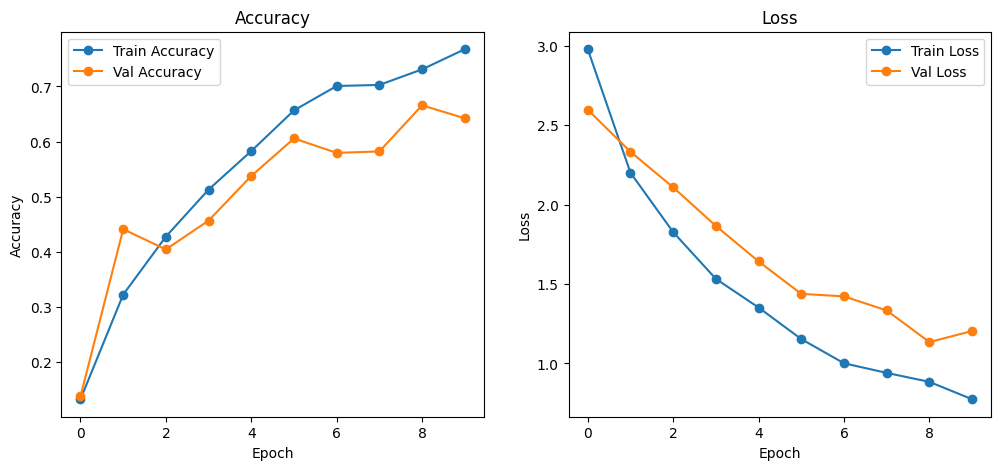

In [102]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy',marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy',marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss',marker='o')
plt.plot(history.history['val_loss'], label='Val Loss',marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [106]:
predictions = model.predict(validation_generator)

y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes


12/12 [==============================] - 7s 538ms/step


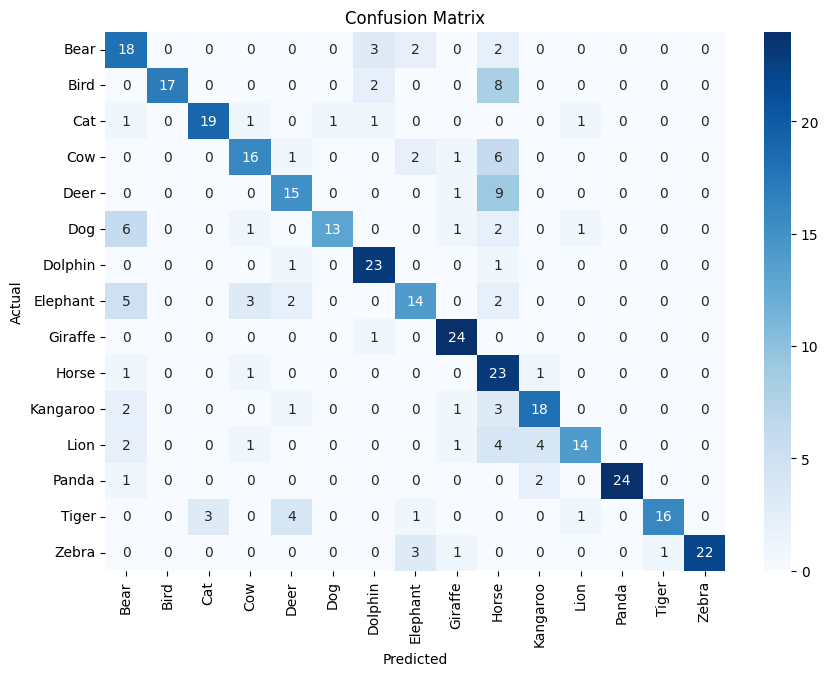

In [107]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [108]:
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

        Bear       0.50      0.72      0.59        25
        Bird       1.00      0.63      0.77        27
         Cat       0.86      0.79      0.83        24
         Cow       0.70      0.62      0.65        26
        Deer       0.62      0.60      0.61        25
         Dog       0.93      0.54      0.68        24
     Dolphin       0.77      0.92      0.84        25
    Elephant       0.64      0.54      0.58        26
     Giraffe       0.80      0.96      0.87        25
       Horse       0.38      0.88      0.53        26
    Kangaroo       0.72      0.72      0.72        25
        Lion       0.82      0.54      0.65        26
       Panda       1.00      0.89      0.94        27
       Tiger       0.94      0.64      0.76        25
       Zebra       1.00      0.81      0.90        27

    accuracy                           0.72       383
   macro avg       0.78      0.72      0.73       383
weighted avg       0.78   